# 动手学深度学习 章节7.6 残差连接 (resnet)

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

定义Residual层

In [2]:
class Residual(nn.Module):
	def __init__(self, input_channel, output_channel, use_1x1_conv=False, stride=1, **kwargs) -> None:
		super().__init__()
		self.conv1 = nn.Conv2d(input_channel, output_channel, 3, padding=1, stride=stride)
		self.batch_norm1 = nn.BatchNorm2d(output_channel)
		self.conv2 = nn.Conv2d(output_channel, output_channel, 3)
		self.batch_norm2 = nn.BatchNorm2d(output_channel)

		if use_1x1_conv:
			self.conv3 = nn.Conv2d(input_channel, output_channel, 1, stride=stride)
		else:
			self.conv3 = None
		
	def forward(self, X):
		Y = F.relu(self.batch_norm1(self.conv1(X)))
		Y = self.batch_norm2(Y)

		if self.conv3:
			X = self.conv3(X)
		
		return F.relu(Y + X)

In [3]:
x = torch.randn(5, 3, 6, 6)
res = Residual(3, 3)
print(res(x).shape)

res = Residual(3, 3, use_1x1_conv=True, stride=2)
print(res(x).shape)

torch.Size([5, 3, 6, 6])
torch.Size([5, 3, 3, 3])


构造resnet块

In [4]:
def resnet_block(input_channel, num_channels, num_residuals, first_block=False):
	"""
	构建resnet块

	Args:
		input_channel: 输入通道数
		num_channels: 输出通道数
		num_residuals: resnet块中的残差块数
		first_block: 是否是第一个块
	"""
	blk = []
	for i in range(num_residuals):
		if i == 0 and not first_block:
			blk.append(Residual(input_channel, num_channels, use_1x1_conv=True, stride=2))
		else:
			blk.append(Residual(num_channels, num_channels))
	return blk

构造resnet网络

In [5]:
b1 = nn.Sequential(
	nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
	nn.BatchNorm2d(64), nn.ReLU(),
	nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

model = nn.Sequential(
	b1, b2, b3, b4, b5, 
	nn.AdaptiveAvgPool2d((1, 1)), 
	nn.Flatten(), 
	nn.Linear(512, 10)
)

In [6]:
x = torch.randn(1, 1, 224, 224)
for layer in model:
	x = layer(x)
	print(layer.__class__.__name__, 'output shape:\t', x.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


训练模型

Finally test acc is 0.90625


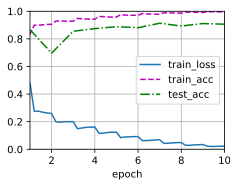

In [7]:
from utils.data.mnist import load_data_fashion_mnist
from utils.train.d2l_train import train_convolution_network

lr, num_epochs, batch_size = 0.05, 10, 256

train_loader, test_loader = load_data_fashion_mnist(batch_size, resize=96)

train_convolution_network(model, train_loader, test_loader, num_epochs, lr, device='cuda:1')